<a href="https://colab.research.google.com/github/AlexGCas/machine-learning/blob/main/clasificacion_covid_radiografia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica #3 : Redes Neuronales Convolucionales
### Clasificación de pacientes en Positivo o Negativo para COVID-19 usando Rayo X de tórax

<ul>
<li>Este Notebook contiene todo el PipeLine para predecir pacientes con Covid-19 positivo usando CNN aplicado a imágenes de Rayos-X de tórax.</li>

<li>El objetivo de esta práctica analizar el código ya preestablecido, usar los inputs() y es encontrar los mejores parámetros de la CNN para obtener los mejores resultados de accuracy.</li>

<li>El código debe ser ubicado en la sección 4. Experimentación > 4.1 Modelo de CNN</li>

<li>Hacer una descripción de la CNN implementada después de explicar los parámetros variados.</li>

<li>Tener una sección de conclusiones con base en los resultados de la experimentación</li>
</ul>


Fuente: https://www.kaggle.com/

In [ ]:
'''from google.colab import drive
import os'''

In [ ]:
'''drive.mount("/content/drive")'''

Mounted at /content/drive


Es posible que necesite hace la intalación de estas librería antes de cargarlas en el proyecto.

In [ ]:
!pip install albumentations --user usuario # Usuario: es el usuario de su computador
!pip install plotly

ERROR: Could not find a version that satisfies the requirement usuario (from versions: none)
ERROR: No matching distribution found for usuario


In [ ]:
levels = ['Normal', 'COVID']

# 1. Carga de la librerías a usar

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Lectura de datos
import os
# os.chdir('/content/drive/MyDrive/infomedicaFinal')
from glob import glob
from PIL import Image

# Procesamiento de datos
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Análisis de datos.
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo de datos y Evaluación de modelos.
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

import keras
import matplotlib.cm as cm

In [ ]:
# Etiqueta de las imágenes que son pacientes Positivos y Negativos para COVID, que serán usadas en Entrenamiento
# validación y test.
levels = ['Normal', 'COVID']

# Imágenes que serán usadas para simular un entorno de producción
levels_new = ['NewX']

# Ruta de las carpetas donde están las imágenes.
# en los archivos compartidos el path cambia a ./data
path = './data' # "../datasets/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    carpeta = os.listdir(os.path.join(data_dir, level))
    for file in carpeta:
        data.append(['{}/{}'.format(level, file), level])
del carpeta
data = pd.DataFrame(data, columns = ['archivo_imagenes', 'Resultados_Covid'])

data['path'] = path + '/' + data['archivo_imagenes']
data['Resultados_Covid'] = data['Resultados_Covid'].map({'Normal': 'Negativos', 'COVID': 'Positivos'})
samples = 13802 # Muestras totales para entrenamiento, validación y prueba.

data.head()

In [ ]:
print('Número de muestras duplicadas: %d'%(data.duplicated().sum()))
print('Número total de muestras: %d'%(data.isnull().value_counts().sum()))

Número de muestras duplicadas: 0
Número total de muestras: 13802


# 2. Análisis exploratorio
- de acuerdo a la gráfica de conteo por clases, en el dataset se presenta un desbalanceo de clases, por lo que en el entrenamiento se utilizará el class_weight para compensarlo.

In [ ]:
df = pd.DataFrame()
df['Resultados_Covid'] = ['Positivos', 'Negativos']
df['Cantidades'] = [len(data[data['Resultados_Covid'] == 'Positivos']), len(data[data['Resultados_Covid'] == 'Negativos'])]
df = df.sort_values(by = ['Cantidades'], ascending = False)

fig = px.bar(df, x = 'Resultados_Covid', y = 'Cantidades', 
             color = "Resultados_Covid", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

## 2.1 Imágenes de muestra

In [ ]:
data['imagen'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))
data.head()

,archivo_imagenes,Resultados_Covid,path,imagen
0,Normal/Normal-9022.png,Negativos,./data/Normal/Normal-9022.png,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,Normal/Normal-9294.png,Negativos,./data/Normal/Normal-9294.png,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Normal/Normal-9403.png,Negativos,./data/Normal/Normal-9403.png,"[[58, 11, 4, 5, 5, 6, 6, 6, 7, 8, 9, 10, 20, 3..."
3,Normal/Normal-9484.png,Negativos,./data/Normal/Normal-9484.png,"[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."
4,Normal/Normal-9031.png,Negativos,./data/Normal/Normal-9031.png,"[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."


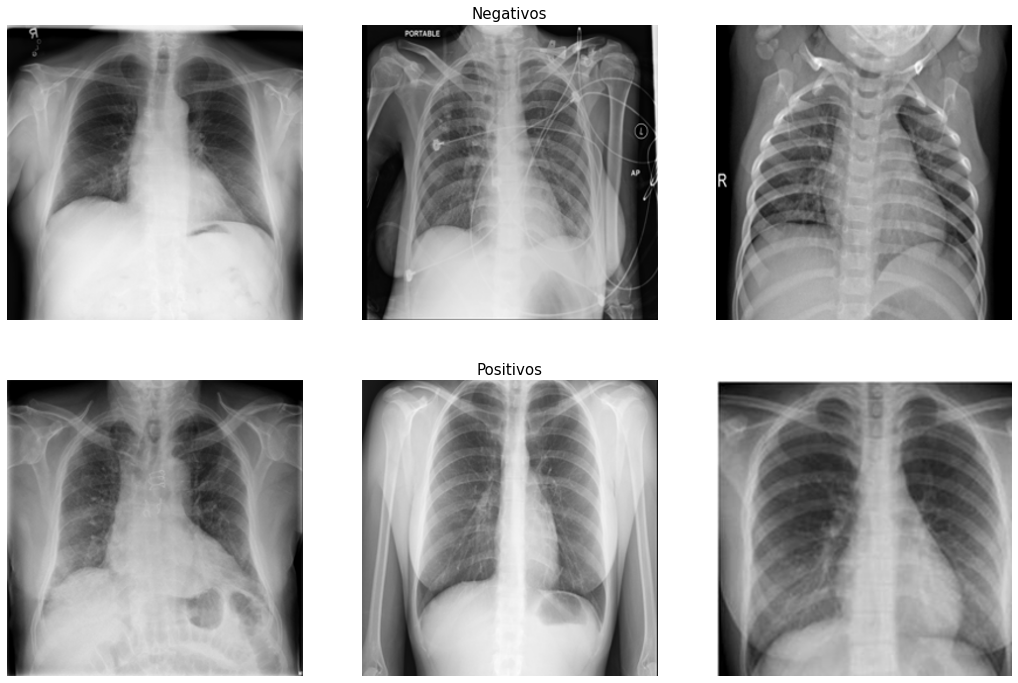

In [ ]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['Resultados_Covid']).groupby('Resultados_Covid')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [ ]:
'''data.to_pickle('datasetReshape.csv')'''

"data.to_pickle('datasetReshape.csv')"

In [ ]:
data = pd.read_pickle('datasetReshape.csv')

## 2.2 Análisis de imagen aleatoria

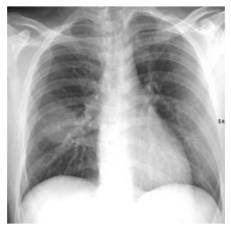

In [ ]:
plt.figure()
image = cv2.imread("./data/COVID/COVID-1002.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [ ]:
print('Dimensiones de la imagen: {}'.format(image.shape))
print('Altura de la imagen: {}'.format(image.shape[0]))
print('Ancho de la imagen: {}'.format(image.shape[1]))
print('Capas de la imagen: {}'.format(image.ndim))
print('Tamaño de la imagen: {}kb'.format(image.size//1024))
print('Tipo de dato de la imagen: {}'.format(image.dtype))
print('Valor de RGB Máximo de la imagen: {}'.format(image.max()))
print('Valor de RGB Mínimo de la imagen: {}'.format(image.min()))

Dimensiones de la imagen: (299, 299, 3)
Altura de la imagen: 299
Ancho de la imagen: 299
Capas de la imagen: 3
Tamaño de la imagen: 261kb
Tipo de dato de la imagen: uint8
Valor de RGB Máximo de la imagen: 255
Valor de RGB Mínimo de la imagen: 5


## 2.3 Distribución del valor de la imagen

In [ ]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(data['imagen'][i].mean())
    std_dev_val.append(np.std(data['imagen'][i]))
    max_val.append(data['imagen'][i].max())
    min_val.append(data['imagen'][i].min())

imageEDA = data.loc[:,['imagen','Resultados_Covid','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

##### Información del gráfico Media vs Densidad para píxeles:

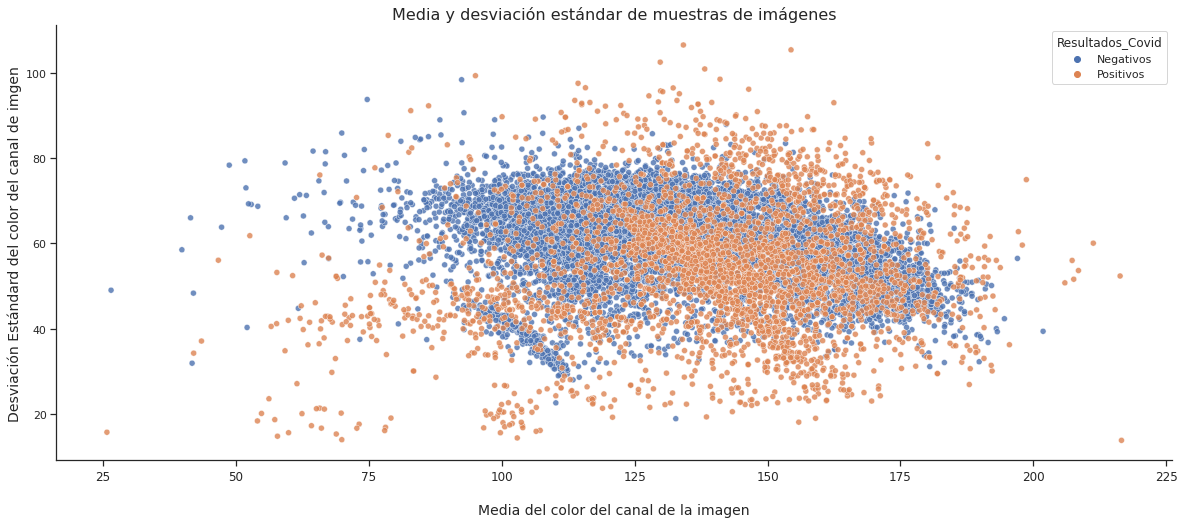

In [ ]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'Resultados_Covid', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nMedia del color del canal de la imagen', fontsize = 14)
ax.set_ylabel('Desviación Estándard del color del canal de imgen', fontsize = 14)
plt.title('Media y desviación estándar de muestras de imágenes', fontsize = 16);
#Media y Deviación Estándard de

Se observa que se forman 2 clusters, uno para Covid Positivo, otro para Covid Negativo y ambos tienen varias superposiciones. Rango medio de color superpuesto: (100 - 175)

Se observa también que para los píxeles que tienen una desviación estándar inferior a 30, todas son imágenes positivas de Covid (de color naranja).

<Figure size 720x576 with 0 Axes>

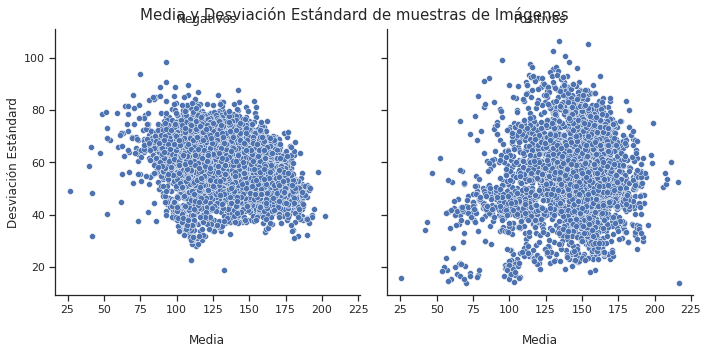

In [ ]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "Resultados_Covid", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Media y Desviación Estándard de muestras de Imágenes', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Desviación Estándard');
for ax in axes:
    ax.set_xlabel('\nMedia');
g.fig.tight_layout();

# 3. Modelado de datos

In [ ]:
all_data = []

# Almacenamiento de imágenes y sus etiquetas en una lista para la división en Train y Test
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['Resultados_Covid'][i] == "Positivos" else 0
    all_data.append([image, label])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-c839e130691e>", line 5, in <module>
    image = cv2.imread(data['path'][i])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py",

KeyboardInterrupt: ignored

In [ ]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Se convierten las imánges a arreglos de Numpy    
x = np.array(x)
y = np.array(y)

# Se hace la separación en muestras para train (80%) y test (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# El 80% de las muestras de Train, se separación en muestras para train (90%) y validación (10%) en la
# etapa de entrenamiento
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(f'''
X para entrenamiento: {x_train.shape}, 
X para Prueba: {x_test.shape}, 
X para validación: {x_val.shape}, 
y de entrenamiento: {y_train.shape}, 
y de prueba: {y_test.shape}, 
y de validación: {y_val.shape}''')

In [ ]:
def guardarArray(nombre, array):
    nombre = "./datosModelo/" + nombre + '.npy'
    with open(nombre, "wb") as f:
        np.save(nombre, array)
def leerArray(nombre):
    nombre = "./datosModelo/" + nombre + '.npy'
    with open(nombre, "rb") as f:
        return np.load(nombre)

In [ ]:
'''
guardarArray("x_train", x_train)
guardarArray("x_test", x_test)
guardarArray("x_val", x_val)
guardarArray("y_train", y_train)
guardarArray("y_test", y_test)
guardarArray("y_val", y_val)
'''

In [ ]:
load_x_train = leerArray('x_train')
load_x_test = leerArray('x_test')
load_x_val = leerArray('x_val')
load_y_train = leerArray('y_train')
load_y_test = leerArray('y_test')
load_y_val = leerArray('y_val')

In [ ]:
load_x_train == x_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

# 4. Experimentación

## 4.1 Modelo de CNN

In [ ]:
!pip install scikeras

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


<img src="img/esquema_cnn.png" width="700px">

In [ ]:
# Construya aquí la CNN con base en la estructura anterior, de igual forma evalue varias configuraciones 
# para obtener el mejor desempeño según las métricas evaluadas en las siguientes celdas del notebook.
# https://www.analyticsvidhya.com/blog/2021/06/building-a-convolutional-neural-network-using-tensorflow-keras/
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# https://medium.com/ml-book/neural-networks-hyperparameter-tuning-in-tensorflow-2-0-a7b4e2b574a1
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://medium.datadriveninvestor.com/overview-of-different-optimizers-for-neural-networks-e0ed119440c3
# https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/#:~:text=and%20recurrent%20connections.-,Dropout%20Rate,rate%2C%20such%20as%20of%200.8.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Flatten,Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.utils import class_weight

# Plantilla para el algoritmo de grid search:
    La siguiente funcion genera un modelo plantilla que permite 
    evaluar parámetros de diferentes capas mediante el algoritmo
    de grid search.
### Fuentes:
    - Modelo plantilla: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
    - Arquitectura de la red: https://towardsdatascience.com/how-to-optimize-learning-rate-with-tensorflow-its-easier-than-you-think-164f980a7c7b
    - Batch size recomendado: https://www.sciencedirect.com/science/article/pii/S2405959519303455#:~:text=In%20practical%20terms%2C%20to%20determine,advantage%20of%20the%20GPUs%20processing.

In [ ]:
def create_model(filters = 16, kernel_size = 3, dropout_rate = 0.1, learning_rate = 0.1, units = 16, dense_dropout_rate = 0.5):
    '''
        create_model crea un entorno para modificar diferentes variables de la
        red neuronal convolucional, retorna un unico modelo evaluable con grid
        search
    '''
    # inicializar el modelo
    model = Sequential()
    # añadir dos capas convolucionales y un max pooling
    model.add(Conv2D(filters, kernel_size = 3, activation = 'relu', input_shape = (70, 70, 3)))
    model.add(Conv2D(2*filters, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    # regularización para evitar overfitting
    model.add(Dropout(dropout_rate))
    # capa convolucional y max pooling
    model.add(Conv2D(2*filters, kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    # regularización
    model.add(Dropout(dropout_rate))
    # convolución y max pooling
    model.add(Conv2D(4*filters, kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    # regularización
    model.add(Dropout(dropout_rate))
    # aplanar para entrada a capa densa
    model.add(Flatten())
    model.add(Dense(units, activation = 'relu'))

    model.add(Dropout(dense_dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    # compilar el modelo
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate = 0.001),metrics=['accuracy'])
    return model

# Creación del "wrapper model"

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=1, filters = 4, kernel_size = 2, dropout_rate = 0.1, learning_rate = 1, units = 16, dense_dropout_rate = 0.5)

# Estrategia para el tuning de los parámetros:



*        Debido a la cantidad de parámetros a ajustar, en lugar de realizar un grid search para tunear todos los parámetros de una sola vez 
        (el número de iteraciones sería el producto de todas las opciones de los parámetros y el cv) se van a realizar un grid search para 
        cada uno de los parámetros individualmente (el número de operaciones será la suma de las opciones para cada parámetro multiplicado 
        por cv)
* El valor del parámetro obtenido en una determinada etápa de  gridsearch será utilizado en las siguientes etápas ajustando los valores por defecto en la función create_model así que los parámetros por defecto de esa función serán configurados como los más óptimos en el entrenamiento del dataset actual.

# Tuning del número de filtros de la convolución

In [ ]:
# define the grid search parameters
# filters = 8, kernel_size = 2, dropout_rate = 0.1, learning_rate = 1, units = 16, dense_dropout_rate = 0.5
filters = [4, 8, 16]
param_gridFilter = dict(filters=filters)
gridFilter = GridSearchCV(estimator=model, param_grid=param_gridFilter, n_jobs=1, cv=3)

In [ ]:
gridFilter.fit(
                load_x_train, load_y_train, 
                epochs = 30, batch_size = 32,  
                validation_data = (load_x_val, load_y_val)
            )

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 31s 149ms/step - loss: 0.5496 - accuracy: 0.7358 - val_loss: 0.5503 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 30s 143ms/step - loss: 0.4928 - accuracy: 0.7449 - val_loss: 0.4471 - val_accuracy: 0.7502
Epoch 3/30
207/207 [==============================] - 29s 138ms/step - loss: 0.4673 - accuracy: 0.7686 - val_loss: 0.4262 - val_accuracy: 0.8027
Epoch 4/30
207/207 [==============================] - 29s 142ms/step - loss: 0.4458 - accuracy: 0.7920 - val_loss: 0.4085 - val_accuracy: 0.8081
Epoch 5/30
207/207 [==============================] - 29s 138ms/step - loss: 0.4271 - accuracy: 0.8059 - val_loss: 0.3908 - val_accuracy: 0.8244
Epoch 6/30
207/207 [==============================] - 29s 138ms/step - loss: 0.4062 - accuracy: 0.8175 - val_loss: 0.3448 - val_accuracy: 0.8489
Epoch 7/30
207/207 [==============================] - 29s 142ms/step - loss: 0.3871 - accuracy: 0.8274 - val_loss: 0.3371 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 33s 154ms/step - loss: 0.5375 - accuracy: 0.7382 - val_loss: 0.4533 - val_accuracy: 0.7484
Epoch 2/30
207/207 [==============================] - 29s 140ms/step - loss: 0.4734 - accuracy: 0.7536 - val_loss: 0.4334 - val_accuracy: 0.7756
Epoch 3/30
207/207 [==============================] - 29s 139ms/step - loss: 0.4505 - accuracy: 0.7640 - val_loss: 0.3982 - val_accuracy: 0.7991
Epoch 4/30
207/207 [==============================] - 29s 139ms/step - loss: 0.4281 - accuracy: 0.7817 - val_loss: 0.3745 - val_accuracy: 0.8443
Epoch 5/30
207/207 [==============================] - 29s 138ms/step - loss: 0.4031 - accuracy: 0.8062 - val_loss: 0.3300 - val_accuracy: 0.8507
Epoch 6/30
207/207 [==============================] - 29s 140ms/step - loss: 0.3783 - accuracy: 0.8297 - val_loss: 0.3185 - val_accuracy: 0.8679
Epoch 7/30
207/207 [==============================] - 29s 140ms/step - loss: 0.3649 - accuracy: 0.8305 - val_loss: 0.2896 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 51s 144ms/step - loss: 0.5844 - accuracy: 0.7334 - val_loss: 0.5042 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 30s 143ms/step - loss: 0.5218 - accuracy: 0.7465 - val_loss: 0.5203 - val_accuracy: 0.7855
Epoch 3/30
207/207 [==============================] - 30s 143ms/step - loss: 0.5046 - accuracy: 0.7604 - val_loss: 0.4574 - val_accuracy: 0.7502
Epoch 4/30
207/207 [==============================] - 30s 143ms/step - loss: 0.4861 - accuracy: 0.7726 - val_loss: 0.4491 - val_accuracy: 0.7810
Epoch 5/30
207/207 [==============================] - 30s 143ms/step - loss: 0.4748 - accuracy: 0.7725 - val_loss: 0.4316 - val_accuracy: 0.7738
Epoch 6/30
207/207 [==============================] - 30s 145ms/step - loss: 0.4496 - accuracy: 0.7844 - val_loss: 0.4125 - val_accuracy: 0.7846
Epoch 7/30
207/207 [==============================] - 30s 144ms/step - loss: 0.4463 - accuracy: 0.7914 - val_loss: 0.3911 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 42s 197ms/step - loss: 0.5344 - accuracy: 0.7366 - val_loss: 0.4980 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 43s 206ms/step - loss: 0.4708 - accuracy: 0.7405 - val_loss: 0.4138 - val_accuracy: 0.7882
Epoch 3/30
207/207 [==============================] - 40s 192ms/step - loss: 0.4249 - accuracy: 0.8010 - val_loss: 0.3729 - val_accuracy: 0.8480
Epoch 4/30
207/207 [==============================] - 40s 192ms/step - loss: 0.4020 - accuracy: 0.8225 - val_loss: 0.3626 - val_accuracy: 0.8534
Epoch 5/30
207/207 [==============================] - 40s 191ms/step - loss: 0.3780 - accuracy: 0.8362 - val_loss: 0.3081 - val_accuracy: 0.8661
Epoch 6/30
207/207 [==============================] - 40s 192ms/step - loss: 0.3543 - accuracy: 0.8451 - val_loss: 0.2937 - val_accuracy: 0.8778
Epoch 7/30
207/207 [==============================] - 39s 189ms/step - loss: 0.3496 - accuracy: 0.8489 - val_loss: 0.3073 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 42s 197ms/step - loss: 0.5614 - accuracy: 0.7361 - val_loss: 0.4875 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 38s 185ms/step - loss: 0.4808 - accuracy: 0.7409 - val_loss: 0.4135 - val_accuracy: 0.7412
Epoch 3/30
207/207 [==============================] - 38s 185ms/step - loss: 0.4554 - accuracy: 0.7381 - val_loss: 0.4089 - val_accuracy: 0.7412
Epoch 4/30
207/207 [==============================] - 45s 215ms/step - loss: 0.4246 - accuracy: 0.7494 - val_loss: 0.3694 - val_accuracy: 0.7991
Epoch 5/30
207/207 [==============================] - 38s 185ms/step - loss: 0.4146 - accuracy: 0.7992 - val_loss: 0.4077 - val_accuracy: 0.8299
Epoch 6/30
207/207 [==============================] - 38s 184ms/step - loss: 0.3949 - accuracy: 0.8167 - val_loss: 0.3299 - val_accuracy: 0.8416
Epoch 7/30
207/207 [==============================] - 39s 189ms/step - loss: 0.3737 - accuracy: 0.8265 - val_loss: 0.3262 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 39s 185ms/step - loss: 0.5358 - accuracy: 0.7360 - val_loss: 0.4410 - val_accuracy: 0.7457
Epoch 2/30
207/207 [==============================] - 39s 187ms/step - loss: 0.4515 - accuracy: 0.7702 - val_loss: 0.3825 - val_accuracy: 0.8290
Epoch 3/30
207/207 [==============================] - 40s 194ms/step - loss: 0.4050 - accuracy: 0.8006 - val_loss: 0.3313 - val_accuracy: 0.8624
Epoch 4/30
207/207 [==============================] - 38s 182ms/step - loss: 0.3807 - accuracy: 0.8217 - val_loss: 0.3455 - val_accuracy: 0.8380
Epoch 5/30
207/207 [==============================] - 38s 183ms/step - loss: 0.3611 - accuracy: 0.8385 - val_loss: 0.3029 - val_accuracy: 0.8715
Epoch 6/30
207/207 [==============================] - 38s 183ms/step - loss: 0.3295 - accuracy: 0.8591 - val_loss: 0.2748 - val_accuracy: 0.8805
Epoch 7/30
207/207 [==============================] - 38s 182ms/step - loss: 0.3203 - accuracy: 0.8596 - val_loss: 0.2879 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 88s 418ms/step - loss: 0.5427 - accuracy: 0.7352 - val_loss: 0.4661 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 92s 443ms/step - loss: 0.4722 - accuracy: 0.7381 - val_loss: 0.4157 - val_accuracy: 0.7412
Epoch 3/30
207/207 [==============================] - 88s 427ms/step - loss: 0.4369 - accuracy: 0.7381 - val_loss: 0.3751 - val_accuracy: 0.7412
Epoch 4/30
207/207 [==============================] - 95s 458ms/step - loss: 0.4097 - accuracy: 0.7864 - val_loss: 0.3725 - val_accuracy: 0.8471
Epoch 5/30
207/207 [==============================] - 100s 484ms/step - loss: 0.3834 - accuracy: 0.8235 - val_loss: 0.3366 - val_accuracy: 0.8570
Epoch 6/30
207/207 [==============================] - 70s 338ms/step - loss: 0.3709 - accuracy: 0.8344 - val_loss: 0.3170 - val_accuracy: 0.8751
Epoch 7/30
207/207 [==============================] - 69s 331ms/step - loss: 0.3511 - accuracy: 0.8433 - val_loss: 0.3028 - val_a

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 75s 361ms/step - loss: 0.5118 - accuracy: 0.7468 - val_loss: 0.4418 - val_accuracy: 0.7548
Epoch 2/30
207/207 [==============================] - 70s 337ms/step - loss: 0.4180 - accuracy: 0.7888 - val_loss: 0.3445 - val_accuracy: 0.8516
Epoch 3/30
207/207 [==============================] - 70s 336ms/step - loss: 0.3718 - accuracy: 0.8296 - val_loss: 0.3290 - val_accuracy: 0.8534
Epoch 4/30
207/207 [==============================] - 70s 336ms/step - loss: 0.3450 - accuracy: 0.8400 - val_loss: 0.2779 - val_accuracy: 0.8842
Epoch 5/30
207/207 [==============================] - 69s 332ms/step - loss: 0.3193 - accuracy: 0.8620 - val_loss: 0.2860 - val_accuracy: 0.8887
Epoch 6/30
207/207 [==============================] - 74s 360ms/step - loss: 0.2984 - accuracy: 0.8691 - val_loss: 0.2643 - val_accuracy: 0.9014
Epoch 7/30
207/207 [==============================] - 69s 332ms/step - loss: 0.2730 - accuracy: 0.8880 - val_loss: 0.2229 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 69s 329ms/step - loss: 0.5582 - accuracy: 0.7378 - val_loss: 0.4804 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 67s 325ms/step - loss: 0.4567 - accuracy: 0.7382 - val_loss: 0.4077 - val_accuracy: 0.7412
Epoch 3/30
207/207 [==============================] - 72s 349ms/step - loss: 0.4223 - accuracy: 0.7657 - val_loss: 0.3642 - val_accuracy: 0.8090
Epoch 4/30
207/207 [==============================] - 69s 332ms/step - loss: 0.3953 - accuracy: 0.8237 - val_loss: 0.3370 - val_accuracy: 0.8579
Epoch 5/30
207/207 [==============================] - 68s 329ms/step - loss: 0.3679 - accuracy: 0.8247 - val_loss: 0.3384 - val_accuracy: 0.8688
Epoch 6/30
207/207 [==============================] - 68s 328ms/step - loss: 0.3585 - accuracy: 0.8354 - val_loss: 0.2952 - val_accuracy: 0.8742
Epoch 7/30
207/207 [==============================] - 68s 327ms/step - loss: 0.3295 - accuracy: 0.8501 - val_loss: 0.2946 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
311/311 [==============================] - 103s 327ms/step - loss: 0.5253 - accuracy: 0.7373 - val_loss: 0.4149 - val_accuracy: 0.7412
Epoch 2/30
311/311 [==============================] - 101s 325ms/step - loss: 0.4231 - accuracy: 0.7702 - val_loss: 0.3889 - val_accuracy: 0.8127
Epoch 3/30
311/311 [==============================] - 103s 330ms/step - loss: 0.3936 - accuracy: 0.8287 - val_loss: 0.3385 - val_accuracy: 0.8552
Epoch 4/30
311/311 [==============================] - 100s 321ms/step - loss: 0.3640 - accuracy: 0.8416 - val_loss: 0.3582 - val_accuracy: 0.8624
Epoch 5/30
311/311 [==============================] - 100s 320ms/step - loss: 0.3395 - accuracy: 0.8575 - val_loss: 0.3303 - val_accuracy: 0.8742
Epoch 6/30
311/311 [==============================] - 100s 321ms/step - loss: 0.3246 - accuracy: 0.8633 - val_loss: 0.3273 - val_accuracy: 0.8588
Epoch 7/30
311/311 [==============================] - 99s 320ms/step - loss: 0.3056 - accuracy: 0.8761 - val_loss: 0.2813 - 

GridSearchCV(cv=3,
             estimator=KerasClassifier(build_fn=<function create_model at 0x7f91e2aa5290>, dense_dropout_rate=0.5, dropout_rate=0.1, filters=4, kernel_size=2, learning_rate=1, units=16),
             n_jobs=1, param_grid={'filters': [4, 8, 16]})

de acuerdo con el grid search realizado el mejor modelo respecto al accurracy se obtiene con 16 

In [ ]:
gridFilter.best_estimator_

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7f91e2aa5290>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	filters=16
	kernel_size=2
	dropout_rate=0.1
	learning_rate=1
	units=16
	dense_dropout_rate=0.5
	class_weight=None
)

# tuning kernel_size

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=1,  kernel_size = 2)

In [ ]:
kernel_size = [2, 3, 5]
param_gridKernel = dict(kernel_size=kernel_size)
gridKernel = GridSearchCV(estimator=model, param_grid=param_gridKernel, n_jobs=1, cv=3) 

In [ ]:
gridKernel.fit(
                load_x_train, load_y_train, 
                epochs = 30, batch_size = 32,  
                validation_data = (load_x_val, load_y_val)
            )

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 72s 339ms/step - loss: 0.5494 - accuracy: 0.7378 - val_loss: 0.4364 - val_accuracy: 0.7864
Epoch 2/30
207/207 [==============================] - 72s 347ms/step - loss: 0.4663 - accuracy: 0.7690 - val_loss: 0.3983 - val_accuracy: 0.8199
Epoch 3/30
207/207 [==============================] - 70s 338ms/step - loss: 0.4311 - accuracy: 0.7859 - val_loss: 0.3598 - val_accuracy: 0.8597
Epoch 4/30
207/207 [==============================] - 70s 337ms/step - loss: 0.3822 - accuracy: 0.8181 - val_loss: 0.3163 - val_accuracy: 0.8796
Epoch 5/30
207/207 [==============================] - 70s 337ms/step - loss: 0.3438 - accuracy: 0.8412 - val_loss: 0.3049 - val_accuracy: 0.8579
Epoch 6/30
207/207 [==============================] - 70s 339ms/step - loss: 0.3119 - accuracy: 0.8570 - val_loss: 0.2461 - val_accuracy: 0.9059
Epoch 7/30
207/207 [==============================] - 71s 345ms/step - loss: 0.2858 - accuracy: 0.8720 - val_loss: 0.2301 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 75s 356ms/step - loss: 0.5803 - accuracy: 0.7354 - val_loss: 0.4941 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 72s 345ms/step - loss: 0.5056 - accuracy: 0.7381 - val_loss: 0.4335 - val_accuracy: 0.7412
Epoch 3/30
207/207 [==============================] - 71s 344ms/step - loss: 0.4716 - accuracy: 0.7381 - val_loss: 0.4134 - val_accuracy: 0.7412
Epoch 4/30
207/207 [==============================] - 71s 345ms/step - loss: 0.4546 - accuracy: 0.7381 - val_loss: 0.4051 - val_accuracy: 0.7412
Epoch 5/30
207/207 [==============================] - 71s 343ms/step - loss: 0.4310 - accuracy: 0.7381 - val_loss: 0.3844 - val_accuracy: 0.7412
Epoch 6/30
207/207 [==============================] - 73s 351ms/step - loss: 0.4171 - accuracy: 0.7381 - val_loss: 0.3401 - val_accuracy: 0.7412
Epoch 7/30
207/207 [==============================] - 72s 347ms/step - loss: 0.4058 - accuracy: 0.7381 - val_loss: 0.3351 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 73s 350ms/step - loss: 0.5312 - accuracy: 0.7378 - val_loss: 0.4394 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 72s 348ms/step - loss: 0.4494 - accuracy: 0.7382 - val_loss: 0.3879 - val_accuracy: 0.7412
Epoch 3/30
207/207 [==============================] - 72s 350ms/step - loss: 0.4161 - accuracy: 0.7954 - val_loss: 0.3714 - val_accuracy: 0.8308
Epoch 4/30
207/207 [==============================] - 72s 350ms/step - loss: 0.3951 - accuracy: 0.8229 - val_loss: 0.3433 - val_accuracy: 0.8516
Epoch 5/30
207/207 [==============================] - 72s 349ms/step - loss: 0.3708 - accuracy: 0.8348 - val_loss: 0.3272 - val_accuracy: 0.8670
Epoch 6/30
207/207 [==============================] - 73s 351ms/step - loss: 0.3364 - accuracy: 0.8530 - val_loss: 0.2874 - val_accuracy: 0.8914
Epoch 7/30
207/207 [==============================] - 72s 350ms/step - loss: 0.3047 - accuracy: 0.8693 - val_loss: 0.2804 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 72s 339ms/step - loss: 0.5421 - accuracy: 0.7373 - val_loss: 0.4382 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 71s 345ms/step - loss: 0.4526 - accuracy: 0.7538 - val_loss: 0.3965 - val_accuracy: 0.8054
Epoch 3/30
207/207 [==============================] - 70s 338ms/step - loss: 0.4136 - accuracy: 0.7911 - val_loss: 0.3604 - val_accuracy: 0.8480
Epoch 4/30
207/207 [==============================] - 71s 342ms/step - loss: 0.3758 - accuracy: 0.8315 - val_loss: 0.3256 - val_accuracy: 0.8561
Epoch 5/30
207/207 [==============================] - 70s 339ms/step - loss: 0.3499 - accuracy: 0.8407 - val_loss: 0.3061 - val_accuracy: 0.8624
Epoch 6/30
207/207 [==============================] - 71s 343ms/step - loss: 0.3237 - accuracy: 0.8587 - val_loss: 0.2902 - val_accuracy: 0.8760
Epoch 7/30
207/207 [==============================] - 71s 342ms/step - loss: 0.3044 - accuracy: 0.8626 - val_loss: 0.2590 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 71s 338ms/step - loss: 0.5361 - accuracy: 0.7375 - val_loss: 0.4430 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 72s 347ms/step - loss: 0.4592 - accuracy: 0.7381 - val_loss: 0.3905 - val_accuracy: 0.7412
Epoch 3/30
207/207 [==============================] - 73s 350ms/step - loss: 0.4282 - accuracy: 0.7580 - val_loss: 0.3639 - val_accuracy: 0.8235
Epoch 4/30
207/207 [==============================] - 72s 348ms/step - loss: 0.3994 - accuracy: 0.8145 - val_loss: 0.3403 - val_accuracy: 0.8624
Epoch 5/30
207/207 [==============================] - 72s 349ms/step - loss: 0.3598 - accuracy: 0.8271 - val_loss: 0.3039 - val_accuracy: 0.8588
Epoch 6/30
207/207 [==============================] - 73s 351ms/step - loss: 0.3503 - accuracy: 0.8404 - val_loss: 0.3201 - val_accuracy: 0.8688
Epoch 7/30
207/207 [==============================] - 73s 351ms/step - loss: 0.3268 - accuracy: 0.8551 - val_loss: 0.2830 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 72s 343ms/step - loss: 0.5319 - accuracy: 0.7375 - val_loss: 0.4607 - val_accuracy: 0.7430
Epoch 2/30
207/207 [==============================] - 74s 356ms/step - loss: 0.4737 - accuracy: 0.7572 - val_loss: 0.3926 - val_accuracy: 0.8253
Epoch 3/30
207/207 [==============================] - 72s 350ms/step - loss: 0.4073 - accuracy: 0.7936 - val_loss: 0.3517 - val_accuracy: 0.8480
Epoch 4/30
207/207 [==============================] - 73s 350ms/step - loss: 0.3745 - accuracy: 0.8160 - val_loss: 0.3418 - val_accuracy: 0.8498
Epoch 5/30
207/207 [==============================] - 72s 350ms/step - loss: 0.3479 - accuracy: 0.8379 - val_loss: 0.3177 - val_accuracy: 0.8615
Epoch 6/30
207/207 [==============================] - 73s 352ms/step - loss: 0.3272 - accuracy: 0.8555 - val_loss: 0.3020 - val_accuracy: 0.8688
Epoch 7/30
207/207 [==============================] - 73s 352ms/step - loss: 0.3012 - accuracy: 0.8629 - val_loss: 0.2794 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 69s 331ms/step - loss: 0.5394 - accuracy: 0.7372 - val_loss: 0.4637 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 70s 338ms/step - loss: 0.4632 - accuracy: 0.7391 - val_loss: 0.4169 - val_accuracy: 0.7412
Epoch 3/30
207/207 [==============================] - 70s 338ms/step - loss: 0.4414 - accuracy: 0.7381 - val_loss: 0.3732 - val_accuracy: 0.7430
Epoch 4/30
207/207 [==============================] - 70s 338ms/step - loss: 0.4145 - accuracy: 0.7941 - val_loss: 0.3331 - val_accuracy: 0.8471
Epoch 5/30
207/207 [==============================] - 71s 342ms/step - loss: 0.3639 - accuracy: 0.8327 - val_loss: 0.3183 - val_accuracy: 0.8661
Epoch 6/30
207/207 [==============================] - 70s 338ms/step - loss: 0.3346 - accuracy: 0.8533 - val_loss: 0.2898 - val_accuracy: 0.8887
Epoch 7/30
207/207 [==============================] - 70s 338ms/step - loss: 0.3191 - accuracy: 0.8637 - val_loss: 0.2788 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 72s 343ms/step - loss: 0.5317 - accuracy: 0.7349 - val_loss: 0.4373 - val_accuracy: 0.7403
Epoch 2/30
207/207 [==============================] - 69s 332ms/step - loss: 0.4367 - accuracy: 0.7592 - val_loss: 0.3509 - val_accuracy: 0.8416
Epoch 3/30
207/207 [==============================] - 68s 330ms/step - loss: 0.3992 - accuracy: 0.7941 - val_loss: 0.3442 - val_accuracy: 0.8652
Epoch 4/30
207/207 [==============================] - 68s 330ms/step - loss: 0.3655 - accuracy: 0.8333 - val_loss: 0.3420 - val_accuracy: 0.8525
Epoch 5/30
207/207 [==============================] - 68s 330ms/step - loss: 0.3490 - accuracy: 0.8451 - val_loss: 0.3021 - val_accuracy: 0.8552
Epoch 6/30
207/207 [==============================] - 68s 331ms/step - loss: 0.3297 - accuracy: 0.8576 - val_loss: 0.2796 - val_accuracy: 0.8887
Epoch 7/30
207/207 [==============================] - 68s 329ms/step - loss: 0.3004 - accuracy: 0.8679 - val_loss: 0.2842 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
207/207 [==============================] - 71s 337ms/step - loss: 0.5966 - accuracy: 0.7354 - val_loss: 0.4601 - val_accuracy: 0.7412
Epoch 2/30
207/207 [==============================] - 70s 337ms/step - loss: 0.5271 - accuracy: 0.7382 - val_loss: 0.5221 - val_accuracy: 0.7412
Epoch 3/30
207/207 [==============================] - 70s 337ms/step - loss: 0.4945 - accuracy: 0.7378 - val_loss: 0.4134 - val_accuracy: 0.7412
Epoch 4/30
207/207 [==============================] - 69s 334ms/step - loss: 0.4709 - accuracy: 0.7382 - val_loss: 0.3890 - val_accuracy: 0.7412
Epoch 5/30
207/207 [==============================] - 69s 334ms/step - loss: 0.4560 - accuracy: 0.7382 - val_loss: 0.3785 - val_accuracy: 0.7412
Epoch 6/30
207/207 [==============================] - 69s 334ms/step - loss: 0.4515 - accuracy: 0.7382 - val_loss: 0.3766 - val_accuracy: 0.7412
Epoch 7/30
207/207 [==============================] - 70s 337ms/step - loss: 0.4464 - accuracy: 0.7382 - val_loss: 0.3662 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
311/311 [==============================] - 105s 335ms/step - loss: 0.5250 - accuracy: 0.7370 - val_loss: 0.4303 - val_accuracy: 0.7412
Epoch 2/30
311/311 [==============================] - 102s 327ms/step - loss: 0.4480 - accuracy: 0.7432 - val_loss: 0.3957 - val_accuracy: 0.7647
Epoch 3/30
311/311 [==============================] - 101s 325ms/step - loss: 0.4098 - accuracy: 0.8155 - val_loss: 0.3536 - val_accuracy: 0.8371
Epoch 4/30
311/311 [==============================] - 101s 324ms/step - loss: 0.3821 - accuracy: 0.8332 - val_loss: 0.3374 - val_accuracy: 0.8416
Epoch 5/30
311/311 [==============================] - 101s 326ms/step - loss: 0.3528 - accuracy: 0.8504 - val_loss: 0.3111 - val_accuracy: 0.8652
Epoch 6/30
311/311 [==============================] - 101s 324ms/step - loss: 0.3251 - accuracy: 0.8658 - val_loss: 0.3062 - val_accuracy: 0.8606
Epoch 7/30
311/311 [==============================] - 101s 325ms/step - loss: 0.2974 - accuracy: 0.8769 - val_loss: 0.2707 -

GridSearchCV(cv=3,
             estimator=KerasClassifier(build_fn=<function create_model at 0x7f77b8f6d950>, kernel_size=2),
             n_jobs=1, param_grid={'kernel_size': [2, 3, 5]})

- Dado que en los gridsearch pasados el entrenamiento se estabiliza al rededor de la época 20 en la mayoria de los casos, se cambiará el número de épocas para disminuir el tiempo de ejecución del algoritmo.
- el grid search anterior indica que el mejor valor (entre los considerados) para el kernel_size es 3

In [ ]:
gridKernel.best_estimator_ 

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7f77b8f6d950>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	kernel_size=3
	class_weight=None
)

# tuning dropout_rate

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=1,  dropout_rate = 0.2)

In [ ]:
dropout_rate = [0.1, 0.15, 0.2]
param_gridDropout = dict(dropout_rate=dropout_rate)
gridDropout = GridSearchCV(estimator=model, param_grid=param_gridDropout, n_jobs=1, cv=3)

In [ ]:
gridDropout.fit(
                load_x_train, load_y_train, 
                epochs = 20, batch_size = 32,  
                validation_data = (load_x_val, load_y_val)
            )

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 71s 338ms/step - loss: 0.5564 - accuracy: 0.7370 - val_loss: 0.4797 - val_accuracy: 0.7403
Epoch 2/20
207/207 [==============================] - 68s 327ms/step - loss: 0.4802 - accuracy: 0.7483 - val_loss: 0.4120 - val_accuracy: 0.7873
Epoch 3/20
207/207 [==============================] - 66s 319ms/step - loss: 0.4430 - accuracy: 0.7734 - val_loss: 0.3649 - val_accuracy: 0.8217
Epoch 4/20
207/207 [==============================] - 68s 327ms/step - loss: 0.4062 - accuracy: 0.8034 - val_loss: 0.3254 - val_accuracy: 0.8561
Epoch 5/20
207/207 [==============================] - 68s 328ms/step - loss: 0.3669 - accuracy: 0.8320 - val_loss: 0.3036 - val_accuracy: 0.8787
Epoch 6/20
207/207 [==============================] - 67s 326ms/step - loss: 0.3460 - accuracy: 0.8356 - val_loss: 0.2703 - val_accuracy: 0.8860
Epoch 7/20
207/207 [==============================] - 67s 325ms/step - loss: 0.3216 - accuracy: 0.8445 - val_loss: 0.2715 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 71s 340ms/step - loss: 0.5369 - accuracy: 0.7367 - val_loss: 0.4224 - val_accuracy: 0.7475
Epoch 2/20
207/207 [==============================] - 69s 335ms/step - loss: 0.4504 - accuracy: 0.7628 - val_loss: 0.3868 - val_accuracy: 0.8072
Epoch 3/20
207/207 [==============================] - 68s 328ms/step - loss: 0.4221 - accuracy: 0.7870 - val_loss: 0.3973 - val_accuracy: 0.8226
Epoch 4/20
207/207 [==============================] - 68s 326ms/step - loss: 0.3817 - accuracy: 0.8161 - val_loss: 0.3209 - val_accuracy: 0.8552
Epoch 5/20
207/207 [==============================] - 68s 330ms/step - loss: 0.3575 - accuracy: 0.8332 - val_loss: 0.3027 - val_accuracy: 0.8561
Epoch 6/20
207/207 [==============================] - 69s 332ms/step - loss: 0.3364 - accuracy: 0.8434 - val_loss: 0.2853 - val_accuracy: 0.8688
Epoch 7/20
207/207 [==============================] - 68s 328ms/step - loss: 0.3195 - accuracy: 0.8555 - val_loss: 0.2916 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 68s 324ms/step - loss: 0.5190 - accuracy: 0.7382 - val_loss: 0.4145 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 69s 335ms/step - loss: 0.4252 - accuracy: 0.7751 - val_loss: 0.3844 - val_accuracy: 0.8362
Epoch 3/20
207/207 [==============================] - 69s 334ms/step - loss: 0.3966 - accuracy: 0.8187 - val_loss: 0.4222 - val_accuracy: 0.7819
Epoch 4/20
207/207 [==============================] - 69s 333ms/step - loss: 0.3642 - accuracy: 0.8354 - val_loss: 0.3130 - val_accuracy: 0.8615
Epoch 5/20
207/207 [==============================] - 71s 342ms/step - loss: 0.3306 - accuracy: 0.8542 - val_loss: 0.2634 - val_accuracy: 0.8851
Epoch 6/20
207/207 [==============================] - 69s 334ms/step - loss: 0.3115 - accuracy: 0.8682 - val_loss: 0.2504 - val_accuracy: 0.8923
Epoch 7/20
207/207 [==============================] - 70s 337ms/step - loss: 0.2882 - accuracy: 0.8803 - val_loss: 0.2600 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 68s 324ms/step - loss: 0.5754 - accuracy: 0.7343 - val_loss: 0.4950 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 69s 333ms/step - loss: 0.4963 - accuracy: 0.7381 - val_loss: 0.4282 - val_accuracy: 0.7412
Epoch 3/20
207/207 [==============================] - 69s 332ms/step - loss: 0.4593 - accuracy: 0.7391 - val_loss: 0.4049 - val_accuracy: 0.7647
Epoch 4/20
207/207 [==============================] - 69s 335ms/step - loss: 0.4302 - accuracy: 0.7662 - val_loss: 0.3831 - val_accuracy: 0.8181
Epoch 5/20
207/207 [==============================] - 69s 331ms/step - loss: 0.4027 - accuracy: 0.8025 - val_loss: 0.3415 - val_accuracy: 0.8317
Epoch 6/20
207/207 [==============================] - 69s 333ms/step - loss: 0.3808 - accuracy: 0.8285 - val_loss: 0.3371 - val_accuracy: 0.8443
Epoch 7/20
207/207 [==============================] - 69s 332ms/step - loss: 0.3588 - accuracy: 0.8428 - val_loss: 0.2898 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 71s 334ms/step - loss: 0.5375 - accuracy: 0.7370 - val_loss: 0.4378 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 69s 332ms/step - loss: 0.4576 - accuracy: 0.7391 - val_loss: 0.3939 - val_accuracy: 0.8317
Epoch 3/20
207/207 [==============================] - 69s 335ms/step - loss: 0.4052 - accuracy: 0.7911 - val_loss: 0.3473 - val_accuracy: 0.8353
Epoch 4/20
207/207 [==============================] - 68s 330ms/step - loss: 0.3761 - accuracy: 0.8213 - val_loss: 0.3271 - val_accuracy: 0.8480
Epoch 5/20
207/207 [==============================] - 69s 331ms/step - loss: 0.3536 - accuracy: 0.8321 - val_loss: 0.3142 - val_accuracy: 0.8633
Epoch 6/20
207/207 [==============================] - 69s 333ms/step - loss: 0.3256 - accuracy: 0.8566 - val_loss: 0.3120 - val_accuracy: 0.8615
Epoch 7/20
207/207 [==============================] - 68s 330ms/step - loss: 0.3222 - accuracy: 0.8554 - val_loss: 0.2934 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 74s 353ms/step - loss: 0.5431 - accuracy: 0.7417 - val_loss: 0.4530 - val_accuracy: 0.7593
Epoch 2/20
207/207 [==============================] - 69s 333ms/step - loss: 0.4654 - accuracy: 0.7563 - val_loss: 0.4142 - val_accuracy: 0.8000
Epoch 3/20
207/207 [==============================] - 69s 332ms/step - loss: 0.4304 - accuracy: 0.7745 - val_loss: 0.3825 - val_accuracy: 0.8416
Epoch 4/20
207/207 [==============================] - 68s 329ms/step - loss: 0.3954 - accuracy: 0.7935 - val_loss: 0.3250 - val_accuracy: 0.8706
Epoch 5/20
207/207 [==============================] - 68s 328ms/step - loss: 0.3640 - accuracy: 0.8348 - val_loss: 0.2997 - val_accuracy: 0.8824
Epoch 6/20
207/207 [==============================] - 70s 340ms/step - loss: 0.3356 - accuracy: 0.8508 - val_loss: 0.2919 - val_accuracy: 0.8670
Epoch 7/20
207/207 [==============================] - 68s 331ms/step - loss: 0.3242 - accuracy: 0.8576 - val_loss: 0.2970 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 69s 330ms/step - loss: 0.5512 - accuracy: 0.7361 - val_loss: 0.4554 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 70s 341ms/step - loss: 0.4585 - accuracy: 0.7367 - val_loss: 0.4059 - val_accuracy: 0.7412
Epoch 3/20
207/207 [==============================] - 70s 340ms/step - loss: 0.4251 - accuracy: 0.7805 - val_loss: 0.3774 - val_accuracy: 0.8109
Epoch 4/20
207/207 [==============================] - 70s 340ms/step - loss: 0.4006 - accuracy: 0.8207 - val_loss: 0.3369 - val_accuracy: 0.8434
Epoch 5/20
207/207 [==============================] - 70s 340ms/step - loss: 0.3618 - accuracy: 0.8428 - val_loss: 0.2967 - val_accuracy: 0.8769
Epoch 6/20
207/207 [==============================] - 70s 339ms/step - loss: 0.3421 - accuracy: 0.8573 - val_loss: 0.2925 - val_accuracy: 0.8778
Epoch 7/20
207/207 [==============================] - 70s 337ms/step - loss: 0.3242 - accuracy: 0.8625 - val_loss: 0.3053 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 72s 343ms/step - loss: 0.5468 - accuracy: 0.7372 - val_loss: 0.4916 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 72s 347ms/step - loss: 0.4709 - accuracy: 0.7402 - val_loss: 0.4122 - val_accuracy: 0.8109
Epoch 3/20
207/207 [==============================] - 71s 342ms/step - loss: 0.4266 - accuracy: 0.7739 - val_loss: 0.3732 - val_accuracy: 0.8362
Epoch 4/20
207/207 [==============================] - 71s 345ms/step - loss: 0.3884 - accuracy: 0.8166 - val_loss: 0.3177 - val_accuracy: 0.8498
Epoch 5/20
207/207 [==============================] - 71s 344ms/step - loss: 0.3580 - accuracy: 0.8370 - val_loss: 0.2890 - val_accuracy: 0.8751
Epoch 6/20
207/207 [==============================] - 71s 342ms/step - loss: 0.3288 - accuracy: 0.8489 - val_loss: 0.2958 - val_accuracy: 0.8814
Epoch 7/20
207/207 [==============================] - 71s 344ms/step - loss: 0.3158 - accuracy: 0.8581 - val_loss: 0.3058 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 70s 334ms/step - loss: 0.5620 - accuracy: 0.7361 - val_loss: 0.5100 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 70s 338ms/step - loss: 0.4863 - accuracy: 0.7381 - val_loss: 0.4213 - val_accuracy: 0.7412
Epoch 3/20
207/207 [==============================] - 69s 335ms/step - loss: 0.4527 - accuracy: 0.7382 - val_loss: 0.4315 - val_accuracy: 0.7412
Epoch 4/20
207/207 [==============================] - 69s 335ms/step - loss: 0.4205 - accuracy: 0.7716 - val_loss: 0.3656 - val_accuracy: 0.8425
Epoch 5/20
207/207 [==============================] - 69s 336ms/step - loss: 0.3911 - accuracy: 0.8136 - val_loss: 0.3512 - val_accuracy: 0.8299
Epoch 6/20
207/207 [==============================] - 70s 337ms/step - loss: 0.3688 - accuracy: 0.8235 - val_loss: 0.3189 - val_accuracy: 0.8624
Epoch 7/20
207/207 [==============================] - 70s 339ms/step - loss: 0.3413 - accuracy: 0.8329 - val_loss: 0.2777 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
311/311 [==============================] - 102s 323ms/step - loss: 0.5315 - accuracy: 0.7382 - val_loss: 0.4317 - val_accuracy: 0.7412
Epoch 2/20
311/311 [==============================] - 99s 318ms/step - loss: 0.4624 - accuracy: 0.7381 - val_loss: 0.3965 - val_accuracy: 0.7412
Epoch 3/20
311/311 [==============================] - 99s 318ms/step - loss: 0.4192 - accuracy: 0.7780 - val_loss: 0.3530 - val_accuracy: 0.8498
Epoch 4/20
311/311 [==============================] - 100s 320ms/step - loss: 0.3689 - accuracy: 0.8230 - val_loss: 0.2983 - val_accuracy: 0.8778
Epoch 5/20
311/311 [==============================] - 100s 320ms/step - loss: 0.3406 - accuracy: 0.8369 - val_loss: 0.2626 - val_accuracy: 0.8923
Epoch 6/20
311/311 [==============================] - 99s 319ms/step - loss: 0.3089 - accuracy: 0.8501 - val_loss: 0.2444 - val_accuracy: 0.8923
Epoch 7/20
311/311 [==============================] - 101s 322ms/step - loss: 0.2851 - accuracy: 0.8696 - val_loss: 0.2320 - va

GridSearchCV(cv=3,
             estimator=KerasClassifier(build_fn=<function create_model at 0x7fd0ef423ef0>, dropout_rate=0.2),
             n_jobs=1, param_grid={'dropout_rate': [0.1, 0.15, 0.2]})

In [ ]:
gridDropout.best_estimator_

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7fd0ef423ef0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	dropout_rate=0.1
	class_weight=None
)

De acuerdo con el gridsearch, entre las opciones consideradas para dropout rate, la mejor es un dropout rate de 0.1

# tuning learning rate

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=1,  learning_rate = 0.1)

In [ ]:
learning_rate = [0.001, 0.01, 0.1]
param_gridLearning = dict(learning_rate=learning_rate)
gridLearning = GridSearchCV(estimator=model, param_grid=param_gridLearning, n_jobs=1, cv=3)


In [ ]:
gridLearning.fit(
                load_x_train, load_y_train, 
                epochs = 20, batch_size = 32,  
                validation_data = (load_x_val, load_y_val)
            )

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 66s 313ms/step - loss: 0.5228 - accuracy: 0.7364 - val_loss: 0.4247 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 67s 324ms/step - loss: 0.4375 - accuracy: 0.7645 - val_loss: 0.3879 - val_accuracy: 0.8380
Epoch 3/20
207/207 [==============================] - 72s 346ms/step - loss: 0.3967 - accuracy: 0.8207 - val_loss: 0.3704 - val_accuracy: 0.8525
Epoch 4/20
207/207 [==============================] - 65s 316ms/step - loss: 0.3861 - accuracy: 0.8244 - val_loss: 0.3695 - val_accuracy: 0.8380
Epoch 5/20
207/207 [==============================] - 66s 317ms/step - loss: 0.3672 - accuracy: 0.8398 - val_loss: 0.3300 - val_accuracy: 0.8769
Epoch 6/20
207/207 [==============================] - 65s 313ms/step - loss: 0.3376 - accuracy: 0.8588 - val_loss: 0.3168 - val_accuracy: 0.8805
Epoch 7/20
207/207 [==============================] - 65s 313ms/step - loss: 0.3472 - accuracy: 0.8582 - val_loss: 0.2991 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 69s 331ms/step - loss: 0.5656 - accuracy: 0.7355 - val_loss: 0.4901 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 68s 327ms/step - loss: 0.5033 - accuracy: 0.7381 - val_loss: 0.4489 - val_accuracy: 0.7412
Epoch 3/20
207/207 [==============================] - 68s 327ms/step - loss: 0.4675 - accuracy: 0.7536 - val_loss: 0.4080 - val_accuracy: 0.8154
Epoch 4/20
207/207 [==============================] - 70s 337ms/step - loss: 0.4276 - accuracy: 0.7713 - val_loss: 0.3699 - val_accuracy: 0.8443
Epoch 5/20
207/207 [==============================] - 69s 331ms/step - loss: 0.4023 - accuracy: 0.7918 - val_loss: 0.3456 - val_accuracy: 0.8154
Epoch 6/20
207/207 [==============================] - 68s 331ms/step - loss: 0.3765 - accuracy: 0.7897 - val_loss: 0.3086 - val_accuracy: 0.8624
Epoch 7/20
207/207 [==============================] - 68s 331ms/step - loss: 0.3628 - accuracy: 0.8051 - val_loss: 0.2923 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 69s 328ms/step - loss: 0.5534 - accuracy: 0.7361 - val_loss: 0.4419 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 69s 332ms/step - loss: 0.4694 - accuracy: 0.7382 - val_loss: 0.4383 - val_accuracy: 0.7412
Epoch 3/20
207/207 [==============================] - 69s 332ms/step - loss: 0.4294 - accuracy: 0.7575 - val_loss: 0.3833 - val_accuracy: 0.8018
Epoch 4/20
207/207 [==============================] - 69s 332ms/step - loss: 0.4042 - accuracy: 0.8188 - val_loss: 0.3690 - val_accuracy: 0.8172
Epoch 5/20
207/207 [==============================] - 69s 332ms/step - loss: 0.3807 - accuracy: 0.8385 - val_loss: 0.3378 - val_accuracy: 0.8597
Epoch 6/20
207/207 [==============================] - 69s 335ms/step - loss: 0.3601 - accuracy: 0.8542 - val_loss: 0.3660 - val_accuracy: 0.8335
Epoch 7/20
207/207 [==============================] - 71s 341ms/step - loss: 0.3368 - accuracy: 0.8634 - val_loss: 0.3216 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 68s 324ms/step - loss: 0.5251 - accuracy: 0.7375 - val_loss: 0.4507 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 68s 330ms/step - loss: 0.4541 - accuracy: 0.7434 - val_loss: 0.3896 - val_accuracy: 0.7674
Epoch 3/20
207/207 [==============================] - 68s 331ms/step - loss: 0.4138 - accuracy: 0.8059 - val_loss: 0.3645 - val_accuracy: 0.8226
Epoch 4/20
207/207 [==============================] - 69s 334ms/step - loss: 0.3800 - accuracy: 0.8312 - val_loss: 0.3623 - val_accuracy: 0.8235
Epoch 5/20
207/207 [==============================] - 70s 336ms/step - loss: 0.3606 - accuracy: 0.8478 - val_loss: 0.3227 - val_accuracy: 0.8552
Epoch 6/20
207/207 [==============================] - 69s 335ms/step - loss: 0.3538 - accuracy: 0.8493 - val_loss: 0.3212 - val_accuracy: 0.8688
Epoch 7/20
207/207 [==============================] - 69s 334ms/step - loss: 0.3299 - accuracy: 0.8712 - val_loss: 0.2920 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 72s 338ms/step - loss: 0.5643 - accuracy: 0.7372 - val_loss: 0.4602 - val_accuracy: 0.7421
Epoch 2/20
207/207 [==============================] - 69s 335ms/step - loss: 0.4715 - accuracy: 0.7569 - val_loss: 0.4009 - val_accuracy: 0.8018
Epoch 3/20
207/207 [==============================] - 69s 333ms/step - loss: 0.4300 - accuracy: 0.7731 - val_loss: 0.3528 - val_accuracy: 0.8543
Epoch 4/20
207/207 [==============================] - 69s 334ms/step - loss: 0.3885 - accuracy: 0.7891 - val_loss: 0.3198 - val_accuracy: 0.8552
Epoch 5/20
207/207 [==============================] - 69s 331ms/step - loss: 0.3792 - accuracy: 0.7915 - val_loss: 0.3012 - val_accuracy: 0.8633
Epoch 6/20
207/207 [==============================] - 70s 337ms/step - loss: 0.3462 - accuracy: 0.8013 - val_loss: 0.2714 - val_accuracy: 0.8968
Epoch 7/20
207/207 [==============================] - 69s 333ms/step - loss: 0.3279 - accuracy: 0.8508 - val_loss: 0.2706 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 70s 334ms/step - loss: 0.5599 - accuracy: 0.7361 - val_loss: 0.4933 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 69s 334ms/step - loss: 0.4861 - accuracy: 0.7382 - val_loss: 0.4238 - val_accuracy: 0.7412
Epoch 3/20
207/207 [==============================] - 69s 333ms/step - loss: 0.4524 - accuracy: 0.7382 - val_loss: 0.3834 - val_accuracy: 0.7412
Epoch 4/20
207/207 [==============================] - 68s 330ms/step - loss: 0.4299 - accuracy: 0.7497 - val_loss: 0.3534 - val_accuracy: 0.8606
Epoch 5/20
207/207 [==============================] - 68s 330ms/step - loss: 0.3888 - accuracy: 0.7902 - val_loss: 0.3630 - val_accuracy: 0.8353
Epoch 6/20
207/207 [==============================] - 69s 331ms/step - loss: 0.3658 - accuracy: 0.8176 - val_loss: 0.2974 - val_accuracy: 0.8733
Epoch 7/20
207/207 [==============================] - 68s 331ms/step - loss: 0.3497 - accuracy: 0.8232 - val_loss: 0.2754 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 69s 329ms/step - loss: 0.5342 - accuracy: 0.7378 - val_loss: 0.4334 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 68s 329ms/step - loss: 0.4554 - accuracy: 0.7384 - val_loss: 0.4034 - val_accuracy: 0.7620
Epoch 3/20
207/207 [==============================] - 68s 330ms/step - loss: 0.4294 - accuracy: 0.8030 - val_loss: 0.3834 - val_accuracy: 0.8416
Epoch 4/20
207/207 [==============================] - 67s 326ms/step - loss: 0.4011 - accuracy: 0.8243 - val_loss: 0.3900 - val_accuracy: 0.8072
Epoch 5/20
207/207 [==============================] - 68s 326ms/step - loss: 0.3886 - accuracy: 0.8332 - val_loss: 0.3314 - val_accuracy: 0.8606
Epoch 6/20
207/207 [==============================] - 67s 325ms/step - loss: 0.3559 - accuracy: 0.8570 - val_loss: 0.3139 - val_accuracy: 0.8787
Epoch 7/20
207/207 [==============================] - 68s 327ms/step - loss: 0.3286 - accuracy: 0.8676 - val_loss: 0.3116 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 68s 326ms/step - loss: 0.5537 - accuracy: 0.7363 - val_loss: 0.4884 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 68s 329ms/step - loss: 0.4883 - accuracy: 0.7381 - val_loss: 0.4194 - val_accuracy: 0.7412
Epoch 3/20
207/207 [==============================] - 68s 329ms/step - loss: 0.4669 - accuracy: 0.7381 - val_loss: 0.3929 - val_accuracy: 0.7412
Epoch 4/20
207/207 [==============================] - 68s 329ms/step - loss: 0.4506 - accuracy: 0.7381 - val_loss: 0.3759 - val_accuracy: 0.7412
Epoch 5/20
207/207 [==============================] - 68s 328ms/step - loss: 0.4288 - accuracy: 0.7379 - val_loss: 0.3649 - val_accuracy: 0.7412
Epoch 6/20
207/207 [==============================] - 68s 331ms/step - loss: 0.4088 - accuracy: 0.7381 - val_loss: 0.3496 - val_accuracy: 0.7412
Epoch 7/20
207/207 [==============================] - 69s 333ms/step - loss: 0.3879 - accuracy: 0.7811 - val_loss: 0.3302 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
207/207 [==============================] - 71s 335ms/step - loss: 0.5442 - accuracy: 0.7370 - val_loss: 0.4510 - val_accuracy: 0.7412
Epoch 2/20
207/207 [==============================] - 66s 320ms/step - loss: 0.4469 - accuracy: 0.7382 - val_loss: 0.3833 - val_accuracy: 0.7412
Epoch 3/20
207/207 [==============================] - 66s 318ms/step - loss: 0.4006 - accuracy: 0.8010 - val_loss: 0.3571 - val_accuracy: 0.8489
Epoch 4/20
207/207 [==============================] - 67s 321ms/step - loss: 0.3598 - accuracy: 0.8412 - val_loss: 0.3291 - val_accuracy: 0.8615
Epoch 5/20
207/207 [==============================] - 66s 319ms/step - loss: 0.3502 - accuracy: 0.8424 - val_loss: 0.3056 - val_accuracy: 0.8661
Epoch 6/20
207/207 [==============================] - 66s 320ms/step - loss: 0.3207 - accuracy: 0.8659 - val_loss: 0.2975 - val_accuracy: 0.8805
Epoch 7/20
207/207 [==============================] - 66s 321ms/step - loss: 0.3093 - accuracy: 0.8694 - val_loss: 0.2774 - val_ac

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
311/311 [==============================] - 99s 315ms/step - loss: 0.5551 - accuracy: 0.7374 - val_loss: 0.4472 - val_accuracy: 0.7412
Epoch 2/20
311/311 [==============================] - 99s 317ms/step - loss: 0.4535 - accuracy: 0.7482 - val_loss: 0.3712 - val_accuracy: 0.7792
Epoch 3/20
311/311 [==============================] - 98s 315ms/step - loss: 0.4033 - accuracy: 0.8010 - val_loss: 0.3522 - val_accuracy: 0.8217
Epoch 4/20
311/311 [==============================] - 99s 317ms/step - loss: 0.3652 - accuracy: 0.8259 - val_loss: 0.3075 - val_accuracy: 0.8724
Epoch 5/20
311/311 [==============================] - 98s 316ms/step - loss: 0.3463 - accuracy: 0.8373 - val_loss: 0.2484 - val_accuracy: 0.8959
Epoch 6/20
311/311 [==============================] - 99s 317ms/step - loss: 0.3219 - accuracy: 0.8523 - val_loss: 0.2552 - val_accuracy: 0.8914
Epoch 7/20
311/311 [==============================] - 98s 316ms/step - loss: 0.2993 - accuracy: 0.8651 - val_loss: 0.2483 - val_ac

GridSearchCV(cv=3,
             estimator=KerasClassifier(build_fn=<function create_model at 0x7fceeb38fa70>, learning_rate=0.1),
             n_jobs=1, param_grid={'learning_rate': [0.001, 0.01, 0.1]})

In [ ]:
gridLearning.best_estimator_

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7fceeb38fa70>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	learning_rate=0.1
	class_weight=None
)

De acuerdo a lo anterior, el mejor valor para el learning rate es de 0.1

# Construcción del mejor modelo
con base a los parámetros optimizados anteriormente se realiza la construcción del modelo

In [ ]:
cnn_model = create_model()

In [ ]:
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 68, 68, 16)        448       
                                                                 
 conv2d_41 (Conv2D)          (None, 66, 66, 32)        4640      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 33, 33, 32)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 33, 33, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                

# 5. Entrenamiento

Antes de realizar el entrenamiento se define el parámetro de class weight debido a que el conteo de positivos es mejor al conteo de negativos

In [ ]:
class_weights = class_weight.compute_class_weight( class_weight = "balanced", classes = np.unique(load_y_train), y = load_y_train  )
class_weights = dict(zip(np.unique(load_y_train), class_weights))

In [ ]:
import datetime
tic = datetime.datetime.now() # Hora de inicio del entrenamiento
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

history = cnn_model.fit(load_x_train, load_y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (load_x_val, load_y_val), 
                        callbacks = [es], class_weight = class_weights)

toc = datetime.datetime.now() # Hora de finalización del entrenamiento
print('Time delay: ',toc-tic)

Epoch 1/50
39/39 [==============================] - 103s 2s/step - loss: 0.3737 - accuracy: 0.8750 - val_loss: 0.2482 - val_accuracy: 0.9195
Epoch 2/50
39/39 [==============================] - 94s 2s/step - loss: 0.3284 - accuracy: 0.8796 - val_loss: 0.2355 - val_accuracy: 0.9068
Epoch 3/50
39/39 [==============================] - 93s 2s/step - loss: 0.3232 - accuracy: 0.8675 - val_loss: 0.2393 - val_accuracy: 0.9014
Epoch 4/50
39/39 [==============================] - 93s 2s/step - loss: 0.2849 - accuracy: 0.8902 - val_loss: 0.2383 - val_accuracy: 0.9050
Epoch 5/50
39/39 [==============================] - 95s 2s/step - loss: 0.3133 - accuracy: 0.8644 - val_loss: 0.2197 - val_accuracy: 0.9176
Epoch 6/50
39/39 [==============================] - 93s 2s/step - loss: 0.2749 - accuracy: 0.8910 - val_loss: 0.2225 - val_accuracy: 0.9122
Epoch 7/50
39/39 [==============================] - 93s 2s/step - loss: 0.2643 - accuracy: 0.8961 - val_loss: 0.2428 - val_accuracy: 0.8941
Epoch 8/50
39/39 [=

Como el algoritmo retorna valores continuos, se utiliza np.where para acondicionar los datos a 0 y 1

In [ ]:
yp_train = cnn_model.predict(load_x_train)
yp_train = np.where(yp_train > 0.5, 1, 0)

yp_val = cnn_model.predict(load_x_val)
yp_val = np.where(yp_val > 0.5, 1, 0)

yp_test = cnn_model.predict(load_x_test)
yp_test = np.where(yp_test > 0.5, 1, 0)

# 6. Evaluación del Modelo

In [ ]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Informe de Clasificación para datos de Entrenamiento\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall:        ", round(recall_score(y_train, yp_train),4))
    print("Especificidad: ", s1)
    print("Accuracy:      ", round(accuracy_score(y_train, yp_train),4))
    print("Precisión:     ", round(precision_score(y_train, yp_train),4))
    print("F1 Score:      ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nInforme de Clasificación para datos de Validación\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall:        ", round(recall_score(y_val, yp_val),4))
    print("Especificidad: ", s2)
    print("Accuracy:      ", round(accuracy_score(y_val, yp_val),4))
    print("Precisión:     ", round(precision_score(y_val, yp_val),4))
    print("F1 Score:      ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nInforme de Clasificación para datos de Prueba\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall:        ", round(recall_score(y_test, yp_test), 4))
    print("Especificidad: ", s3)
    print("Accuracy:      ", round(accuracy_score(y_test, yp_test), 4))
    print("Precisión:     ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score:      ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()

# Analisis de los resultados de datos de prueba
- El algoritmo presenta una especificidad del 93%, es decir, un paciente sin coronavirus será clasificado como paciente sin coronavirus 93 de cada 100 veces y será clasificado como paciente con coronavirus unas 7 de cada 100 veces.
- Sensibilidad (recall) del 92%, es decir, un paciente con coronavirus será clasificado como paciente con coronavirus 92 de cada 100 veces. 
- Dado que es más conveniente detectar los pacientes con coronavirus que los pacientes que no lo tienen (para aíslarlos y tratarlos) una mejora en el algoritmo debería estar centrada en mejorar la sensibilidad del algoritmo en lugar de centrarse en la accuracy.


-----------------------------Convolution Neural Network-----------------------------

Informe de Clasificación para datos de Entrenamiento

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      7334
           1       0.86      0.99      0.92      2602

    accuracy                           0.96      9936
   macro avg       0.93      0.97      0.95      9936
weighted avg       0.96      0.96      0.96      9936

--------------------------------------------------------------------------
Recall:         0.9931
Especificidad:  0.9448
Accuracy:       0.9574
Precisión:      0.8645
F1 Score:       0.9243
--------------------------------------------------------------------------

Informe de Clasificación para datos de Validación

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       819
           1       0.82      0.95      0.88       286

    accuracy                           0.93      11

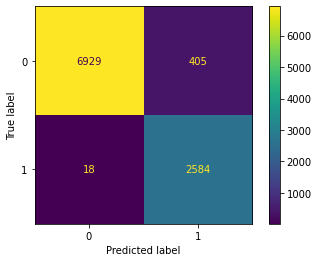

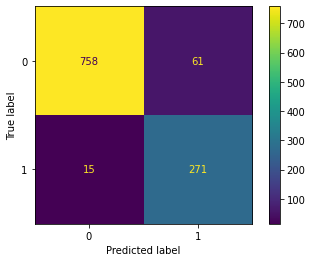

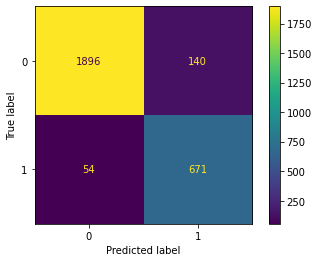

In [ ]:
evaluation_parametrics("Convolution Neural Network", load_y_train, yp_train, load_y_val, yp_val, load_y_test, yp_test)

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


La gráfica de la precisión indica que la presición aumentó con las iteraciones hasta entrar a una zona asintótica en la que con más iteraciones no se presenta un aumento significativo en la presición.

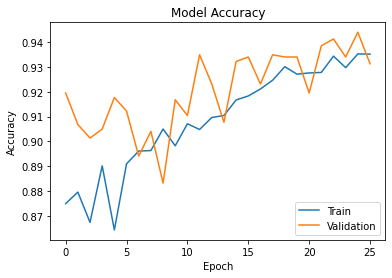

In [ ]:
# Accuracy de Train y Val vs Épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

En la gráfica, para la función de pérdida se observa que en general se mantiene decreciente, por lo que no alcanzó el overfitting.

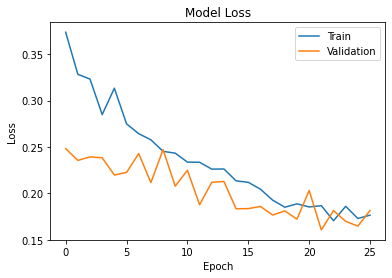

In [ ]:
# Loss para Train y Val vs Épocas 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

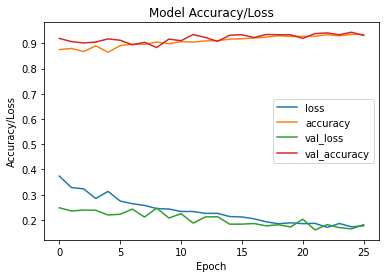

In [ ]:
# Resumen de las anteriores
pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

# Predicción en producción
- como se observa en las celdas posteriores, el algoritmo en producción realizó todas las predicciones correctamente, tanto para sanos como para positivos de covid, esto es consistente con los datos obtenidos sobre la especificidad y sensibilidad del modelo.

In [ ]:
# Positivos: COVID-3614.png , COVID-3615.png  , COVID-3616.png , 
# Negativos: Normal-10190.png  , Normal-10191.png , Normal-10192.png 

# path_new = "../datasets/COVID-19_Radiography_Dataset/NewX/COVID-3614.png"
path_new = "./data/NewX/Normal-10190.png"
image = cv2.imread(path_new)
image = cv2.resize(image, (70, 70)) / 255.0
predict_new = cnn_model.predict(np.array([image]))
print('Datos de la salida por etiqueta: ', predict_new)
print('Etiqueta: ',np.where( predict_new > 0.5, 1, 0))

Datos de la salida por etiqueta:  [[0.00253403]]
Etiqueta:  [[0]]


In [ ]:
path_new = "./data/NewX/Normal-10191.png"
image = cv2.imread(path_new)
image = cv2.resize(image, (70, 70)) / 255.0
predict_new = cnn_model.predict(np.array([image]))
print('Datos de la salida por etiqueta: ', predict_new)
print('Etiqueta: ',np.where( predict_new > 0.5, 1, 0))

Datos de la salida por etiqueta:  [[4.9983853e-05]]
Etiqueta:  [[0]]


In [ ]:
path_new = "./data/NewX/Normal-10192.png"
image = cv2.imread(path_new)
image = cv2.resize(image, (70, 70)) / 255.0
predict_new = cnn_model.predict(np.array([image]))
print('Datos de la salida por etiqueta: ', predict_new)
print('Etiqueta: ',np.where( predict_new > 0.5, 1, 0))

Datos de la salida por etiqueta:  [[6.144868e-10]]
Etiqueta:  [0]


In [ ]:
path_new = "./data/NewX/COVID-3614.png"
image = cv2.imread(path_new)
image = cv2.resize(image, (70, 70)) / 255.0
predict_new = cnn_model.predict(np.array([image]))
print('Datos de la salida por etiqueta: ', predict_new)
print('Etiqueta: ', np.where( predict_new > 0.5, 1, 0))

Datos de la salida por etiqueta:  [[0.76732814]]
Etiqueta:  [[1]]


In [ ]:
path_new = "./data/NewX/COVID-3615.png"
image = cv2.imread(path_new)
image = cv2.resize(image, (70, 70)) / 255.0
predict_new = cnn_model.predict(np.array([image]))
print('Datos de la salida por etiqueta: ', predict_new)
print('Etiqueta: ',np.where( predict_new > 0.5, 1, 0))

Datos de la salida por etiqueta:  [[0.98396575]]
Etiqueta:  [[1]]


In [ ]:
path_new = "./data/NewX/COVID-3614.png"
image = cv2.imread(path_new)
image = cv2.resize(image, (70, 70)) / 255.0
predict_new = cnn_model.predict(np.array([image]))
print('Datos de la salida por etiqueta: ', predict_new)
print('Etiqueta: ',np.where( predict_new > 0.5, 1, 0))

Datos de la salida por etiqueta:  [[0.76732814]]
Etiqueta:  [[1]]
